/var/folders/qd/zmwxbd7j74dc0tnmftc7mnhm0000gn/T/ipykernel_13862/952768459.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


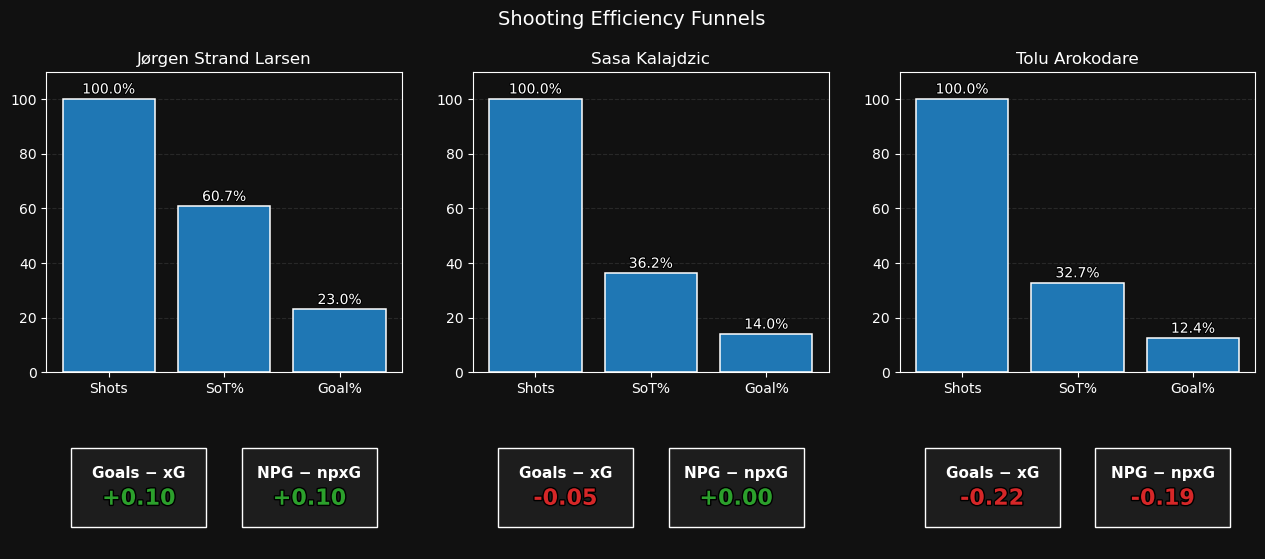

In [ ]:
WORKBOOK  = "stcomp.xlsx"
SHEET     = "Sheet 1"
SHOW_FIGS = True

import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import re, unicodedata
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

FIG_BG   = AX_BG = "#111111"
TILE_BG  = "#1d1d1d"
TILE_EDGE= "white"
POS_COLOR= "#2ca02c"
NEG_COLOR= "#d62728"

mpl.rcParams.update({
    "figure.facecolor": FIG_BG,
    "axes.facecolor": AX_BG,
    "savefig.facecolor": FIG_BG,
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "grid.alpha": 0.15,
})

def stroke_txt(lw=1.5):
    return [path_effects.Stroke(linewidth=lw, foreground="black"), path_effects.Normal()]

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s)).strip().lower()
    s = s.replace("—","-").replace("–","-").replace("−","-")
    s = re.sub(r"\s+", " ", s)
    return s

STAT_CANON = {
    "shots total": "Shots Total", "shots": "Shots Total", "shot": "Shots Total",
    "shots on target": "Shots on target", "sot": "Shots on target", "shot on target": "Shots on target",
    "non-penalty goals": "Non-Penalty Goals", "npg": "Non-Penalty Goals",
    "xg: expected goals": "xG: Expected Goals", "xg": "xG: Expected Goals",
    "npxg: non-penalty xg": "npxG: Non-Penalty xG", "npxg": "npxG: Non-Penalty xG",
    "xag: exp. assisted goals": "xAG: Exp. Assisted Goals", "xag": "xAG: Exp. Assisted Goals",
    "npxg + xag": "npxG + xAG", "npxg+xag": "npxG + xAG",
    "goals": "Goals",
}
def canon_stat(s):
    key = _norm(s)
    return STAT_CANON.get(key, s)

# ---------- LOAD ----------
raw = pd.read_excel(WORKBOOK, sheet_name=SHEET)
raw.columns = [str(c).strip() for c in raw.columns]

def is_long(df):
    cols = set([c.lower() for c in df.columns])
    return {"player", "stat", "per90"}.issubset(cols)

def wide_to_long(df):
    """
    Expect columns like:
      [Stat] | [PlayerA p90] | [Unnamed (PlayerA pct?)] | [PlayerB p90] | [Unnamed (PlayerB pct?)] | ...
    We'll parse first column as Stat, then for the remaining columns, group them in 1–2 column chunks:
      - first in the chunk: Per90
      - optional second: Percentile
    """
    if df.columns[0].lower() not in ("stat", "metric"):
        df = df.rename(columns={df.columns[0]: "Stat"})
    else:
        df = df.rename(columns={df.columns[0]: "Stat"})

    cols = list(df.columns)
    blocks, i, last_named = [], 1, None
    while i < len(cols):
        c_per90 = cols[i]
        c_pct   = cols[i+1] if i+1 < len(cols) else None

        p_name = c_per90 if not str(c_per90).lower().startswith("unnamed") else last_named
        if p_name is None and c_pct and not str(c_pct).lower().startswith("unnamed"):
            p_name = c_pct
        p_name = str(p_name).strip()
        last_named = p_name if not str(c_per90).lower().startswith("unnamed") else last_named

        blocks.append((p_name, c_per90, c_pct))
        i += 2 if c_pct is not None else 1

    rows = []
    for _, r in df.iterrows():
        stat_raw = r["Stat"]
        stat = canon_stat(stat_raw)
        for p_name, c_per90, c_pct in blocks:
            if not p_name or str(p_name).lower().startswith("unnamed"):
                continue
            per90 = r.get(c_per90, np.nan)
            pct   = r.get(c_pct,   np.nan) if c_pct in df.columns else np.nan
            if (pd.isna(per90) or per90=="") and (pd.isna(pct) or pct==""):
                continue
            rows.append({"Player": p_name, "Stat": stat, "Per90": per90, "Percentile": pct})
    out = pd.DataFrame(rows)
    out["Player"] = out["Player"].astype(str).str.strip()
    return out

if is_long(raw):
    df_long = raw.rename(columns={c: c.title() for c in raw.columns})
else:
    df_long = wide_to_long(raw)

for col in ["Player","Stat","Per90"]:
    if col not in df_long.columns:
        raise RuntimeError(f"Could not construct long format with columns Player/Stat/Per90. Got: {list(df_long.columns)}")

df_long["Stat"] = df_long["Stat"].map(canon_stat)

P = df_long.pivot_table(index="Stat", columns="Player", values="Per90", aggfunc="first")
players = list(P.columns)
if len(players) < 2:
    print(f"Warning: expected 2 players, found {len(players)} -> {players}")

def get(pname: str, key: str, default=np.nan):
    try:
        return float(P.loc[key, pname])
    except Exception:
        return default

def metrics_for_player(p):
    shots = get(p, "Shots Total")
    sot   = get(p, "Shots on target")
    npg   = get(p, "Non-Penalty Goals")
    npxg  = get(p, "npxG: Non-Penalty xG")
    goals = get(p, "Goals")
    xg    = get(p, "xG: Expected Goals")

    def nz(x): return np.nan if (pd.isna(x) or x < 0) else x
    shots, sot, npg, npxg, goals, xg = map(nz, [shots, sot, npg, npxg, goals, xg])

    sot_pct   = (sot / shots * 100.0) if (shots and shots>0 and not pd.isna(sot)) else np.nan
    goal_pct  = (npg / shots * 100.0) if (shots and shots>0 and not pd.isna(npg)) else np.nan

    delta_gxg   = (goals - xg)  if (not pd.isna(goals) and not pd.isna(xg))   else np.nan
    delta_npgxg = (npg   - npxg)if (not pd.isna(npg)   and not pd.isna(npxg)) else np.nan

    return dict(
        shots=shots, sot=sot, npg=npg, npxg=npxg, goals=goals, xg=xg,
        sot_pct=sot_pct, goal_pct=goal_pct,
        delta_gxg=delta_gxg, delta_npgxg=delta_npgxg
    )

M = {p: metrics_for_player(p) for p in players}

def funnel_triplet(ax, shots, sot, npg, title):
    sot_pct = (sot/shots*100) if (shots and shots>0 and not pd.isna(sot)) else np.nan
    goal_pct= (npg/shots*100) if (shots and shots>0 and not pd.isna(npg)) else np.nan
    labels = ["Shots", "SoT%", "Goal%"]
    vals   = [100.0, sot_pct, goal_pct]
    bars = ax.bar(labels, vals, edgecolor="white", linewidth=1.1)
    ax.set_ylim(0, 110)
    ax.set_title(title, fontsize=12)
    for b,v in zip(bars, vals):
        ax.text(b.get_x()+b.get_width()/2, (v if not pd.isna(v) else 0)+2,
                f"{v:.1f}%" if not pd.isna(v) else "—",
                ha="center", fontsize=10, path_effects=stroke_txt())
    ax.grid(axis="y", ls="--"); ax.set_axisbelow(True)

def draw_delta_cards(ax, goals, xg, npg, npxg):
    ax.set_axis_off()
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)

    def fmt(v): return "—" if pd.isna(v) else f"{v:+.2f}"
    def col(v): return "white" if pd.isna(v) else (POS_COLOR if v >= 0 else NEG_COLOR)

    d1 = goals - xg  if (not pd.isna(goals) and not pd.isna(xg))   else np.nan
    d2 = npg   - npxg if (not pd.isna(npg)   and not pd.isna(npxg)) else np.nan

    BOX_W, BOX_H = 0.38, 0.64
    GAP          = 0.10
    MARGIN_LR    = max(0.0, (1.0 - (2*BOX_W + GAP)) / 2.0)  # center the pair

    x1 = MARGIN_LR
    x2 = x1 + BOX_W + GAP
    y  = 0.18

    tiles = [
        (x1, "Goals − xG",   d1),
        (x2, "NPG − npxG",   d2),
    ]

    for x, title, val in tiles:
        # sharp-corner tile
        rect = Rectangle((x, y), BOX_W, BOX_H, linewidth=1.0,
                         edgecolor=TILE_EDGE, facecolor=TILE_BG)
        ax.add_patch(rect)
        # title
        ax.text(x + BOX_W/2, y + BOX_H*0.68, title,
                ha="center", va="center", fontsize=11, fontweight="bold", color="white")
        # value
        ax.text(x + BOX_W/2, y + BOX_H*0.36, fmt(val),
                ha="center", va="center", fontsize=16, fontweight="bold",
                color=col(val), path_effects=stroke_txt(2.0))

cols = max(1, len(players))
fig = plt.figure(figsize=(5.2*cols, 6.2))
gs = GridSpec(nrows=2, ncols=cols, height_ratios=[3.4, 1.4], hspace=0.25, figure=fig)
fig.patch.set_facecolor(FIG_BG)

axs_top = [fig.add_subplot(gs[0, i]) for i in range(cols)]
axs_bot = [fig.add_subplot(gs[1, i]) for i in range(cols)]

for ax, p in zip(axs_top, players):
    ax.set_facecolor(AX_BG)
    mp = M[p]
    funnel_triplet(ax, mp["shots"], mp["sot"], mp["npg"], p)

for axb, p in zip(axs_bot, players):
    mp = M[p]
    draw_delta_cards(axb, mp["goals"], mp["xg"], mp["npg"], mp["npxg"])

fig.suptitle("Shooting Efficiency Funnels", fontsize=14)
plt.tight_layout()
if SHOW_FIGS:
    plt.show()


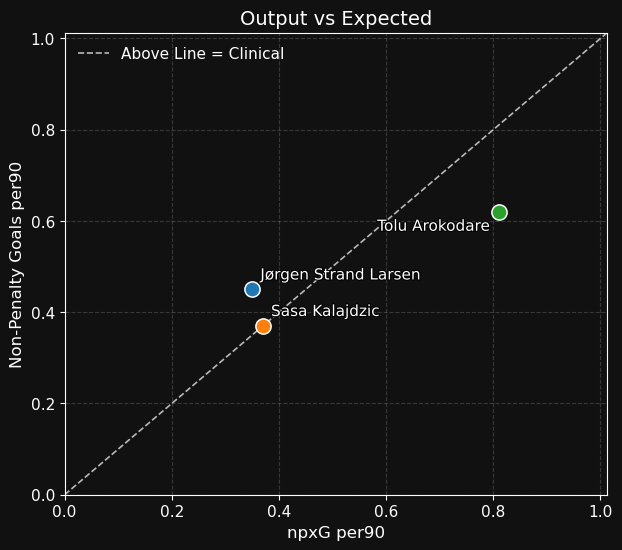

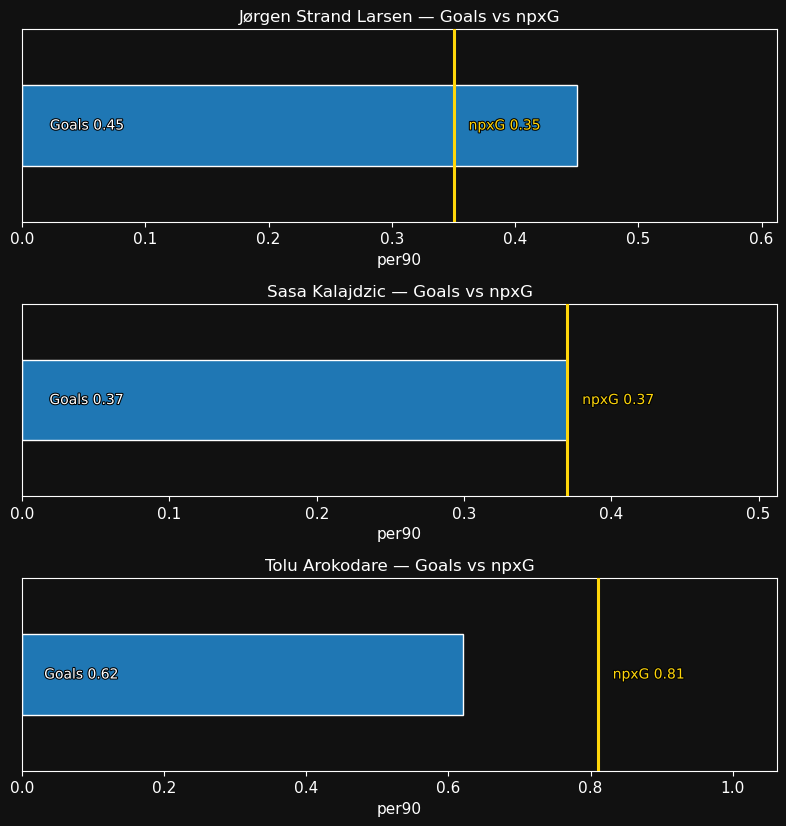

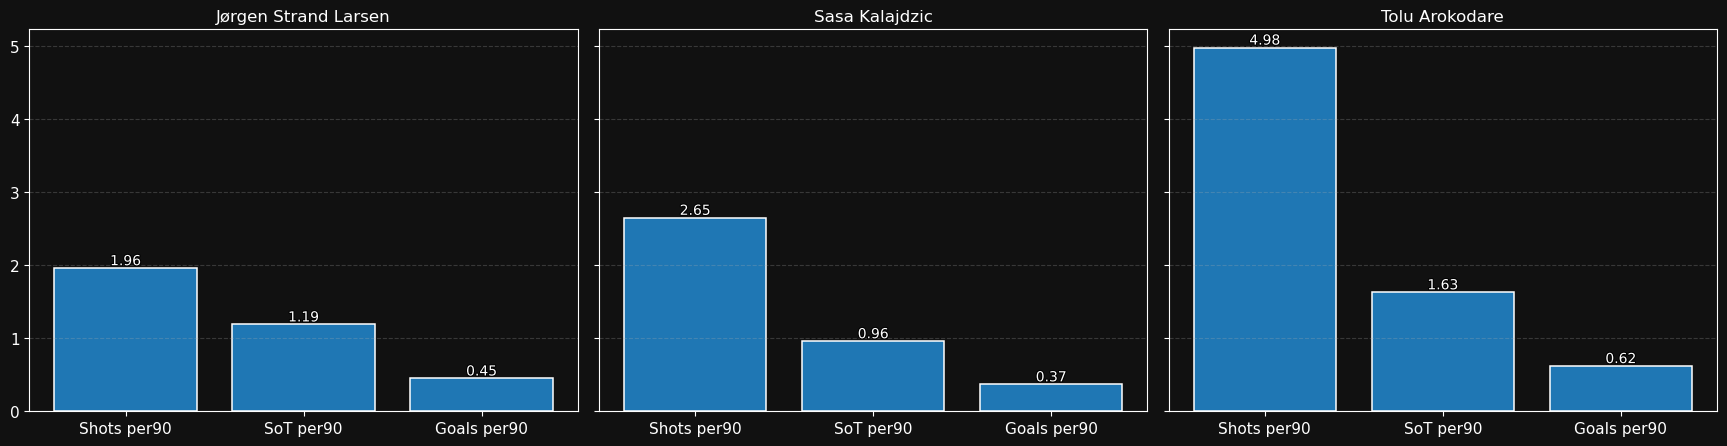

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def _safe_div(a, b):
    return (a / b) if (b and b>0 and not (pd.isna(a) or pd.isna(b))) else np.nan

shots      = [M[p]["shots"] for p in players]
sot        = [M[p]["sot"]   for p in players]
goals_npg  = [M[p]["npg"]   for p in players]
npxg       = [M[p]["npxg"]  for p in players]
sot_pct    = [M[p]["sot_pct"] for p in players]
conv_pct   = [M[p]["conv_pct"] for p in players]
xg_pshot   = [_safe_div(M[p]["npxg"], M[p]["shots"]) for p in players]
g_pshot    = [_safe_div(M[p]["npg"],  M[p]["shots"]) for p in players]
delta_gxg  = [M[p]["delta_gxg"] for p in players]

#output v expected
fig, ax = plt.subplots(figsize=(7.0,6.0))
fig.patch.set_facecolor(FIG_BG); ax.set_facecolor(AX_BG)

max_val = np.nanmax([*(npxg or [0]), *(goals_npg or [0]), 0]) or 0.01
max_val = float(max(0.2, max_val * 1.25))

ax.set_xlim(0, max_val); ax.set_ylim(0, max_val)

ax.plot([0, max_val], [0, max_val], ls="--", color="white", lw=1.2, alpha=0.7,
        label="Above Line = Clinical ")

for i, p in enumerate(players):
    x = npxg[i]; y = goals_npg[i]
    if pd.isna(x) or pd.isna(y):
        continue
    ax.scatter([x], [y], s=120, edgecolor="white", linewidth=1.1, zorder=3)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
dx = 0.015 * (x_max - x_min)
dy = 0.015 * (y_max - y_min)

for i, p in enumerate(players):
    x = npxg[i]; y = goals_npg[i]
    if pd.isna(x) or pd.isna(y):
        continue

    left_space  = x - x_min
    right_space = x_max - x
    down_space  = y - y_min
    up_space    = y_max - y

    off_x = dx if right_space >= left_space else -dx
    off_y = dy if up_space    >= down_space else -dy

    tx = x + off_x
    ty = y + off_y

    tx = np.clip(tx, x_min + dx, x_max - dx)
    ty = np.clip(ty, y_min + dy, y_max - dy)

    ha = "left" if off_x > 0 else "right"
    va = "bottom" if off_y > 0 else "top"

    ax.text(tx, ty, p, ha=ha, va=va, fontsize=11,
            path_effects=stroke_txt(), zorder=4)

ax.set_xlabel("npxG per90", fontsize=12)
ax.set_ylabel("Non-Penalty Goals per90", fontsize=12)
ax.set_title("Output vs Expected", fontsize=14)
ax.grid(True, ls="--", alpha=0.25)
ax.legend(frameon=False)
if SHOW_FIGS: plt.show()


#npxG v Goals
def bullet(ax, base_val, marker_val, title, xlabel="per90",
           goal_bar_color="#1f77b4", xg_line_color="#ffd60a"):
    """
    base_val   -> Goals (per90), drawn as horizontal bar
    marker_val -> npxG (per90), drawn as vertical line (yellow)
    Labels:
      - Goals text inside the bar, left-aligned (white on blue)
      - npxG text just outside the yellow line
    """
    gv = 0.0 if pd.isna(base_val) else float(base_val)
    xv = 0.0 if pd.isna(marker_val) else float(marker_val)

    maxv = np.nanmax([gv, xv, 0]) * 1.25 + 0.05
    maxv = max(maxv, 0.2)

    ax.barh([0], [gv], height=0.5, color=goal_bar_color, edgecolor="white", zorder=1)
    ax.axvline(xv, color=xg_line_color, lw=2.2, zorder=3)

    ax.set_yticks([])
    ax.set_xlim(0, maxv)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontsize=12)

    ax.text(gv * 0.05, 0, f"Goals {gv:.2f}",
            ha="left", va="center", fontsize=10,
            color="white", path_effects=stroke_txt())

    ax.text(xv + 0.02*maxv, 0, f"npxG {xv:.2f}",
            ha="left", va="center", fontsize=10,
            color=xg_line_color, path_effects=stroke_txt())

cols = len(players)
fig, axs = plt.subplots(cols, 1, figsize=(8, 2.8*cols))
if cols == 1: axs = [axs]
fig.patch.set_facecolor(FIG_BG)

for ax, p in zip(axs, players):
    ax.set_facecolor(AX_BG)
    bullet(ax,
           base_val=(M[p]["npg"] or 0),
           marker_val=(M[p]["npxg"] or 0),
           title=f"{p} — Goals vs npxG")

plt.tight_layout()
if SHOW_FIGS: plt.show()

#pipeline
def shots_to_sot(shots_val, sot_pct_val):
    return shots_val * (sot_pct_val/100.0) if not (pd.isna(shots_val) or pd.isna(sot_pct_val)) else np.nan

def sot_to_goals(sot_p90, conv_over_sot_pct):
    return np.nan

fig, axs = plt.subplots(1, len(players), figsize=(5.8*len(players), 4.6), sharey=True)
if len(players) == 1: axs = [axs]
fig.patch.set_facecolor(FIG_BG)

for ax, p in zip(axs, players):
    ax.set_facecolor(AX_BG)
    s = M[p]["shots"]
    sp = M[p]["sot_pct"]
    g = M[p]["npg"]
    sot_p90 = shots_to_sot(s, sp)

    stages = ["Shots per90", "SoT per90", "Goals per90"]
    vals = [s, sot_p90, g]

    bars = ax.bar(stages, vals, edgecolor="white", linewidth=1.1)
    for b, v in zip(bars, vals):
        txt = f"{v:.2f}" if not pd.isna(v) else "—"
        ax.text(b.get_x()+b.get_width()/2, (v if not pd.isna(v) else 0) + (0.04 if (not pd.isna(v)) else 0),
                txt, ha="center", fontsize=10, path_effects=stroke_txt())

    ax.set_title(f"{p}", fontsize=12)
    ax.grid(axis="y", ls="--", alpha=0.25)

# plt.suptitle("Shooting Pipeline (per90)", fontsize=14)
plt.tight_layout()
if SHOW_FIGS: plt.show()
